In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from sklearn.grid_search import GridSearchCV

/Users/matt/scenicstroll/scenic-env/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [3]:
cols = [
    'id',
    'owner',
    'title',
    'datetaken',
    'ownername',
    'views',
    'latitude',
    'longitude',
    'url_n',
    'width',
    'height']

photos = pd.read_csv('../data/photometa00.csv', usecols=cols)
photos = photos.drop_duplicates()
photos = photos[(photos.latitude != 0) & 
                (photos.longitude != 0)]

In [4]:
len(photos)

236632

In [19]:
Xtrain = np.vstack((photos.longitude, photos.latitude)).T
Xtrain *= np.pi/180
Xtrain

array([[-2.13266567,  0.66028923],
       [-2.13415506,  0.65964963],
       [-2.13660517,  0.65935043],
       ..., 
       [-2.13647663,  0.65951699],
       [-2.136301  ,  0.65958471],
       [-2.13637945,  0.65686707]])

In [ ]:
dbs = DBSCAN(eps=1/6000, metric='haversine', min_samples=10)
dbs.fit(Xtrain)
outlier = (dbs.labels_ == -1)
Xtrain = Xtrain[~outlier]
photos = photos[~outlier]

In [ ]:
#photos.to_csv('photos-filtered.csv')

In [5]:
photos = pd.read_csv('photos-filtered.csv')
Xtrain = np.vstack((photos.longitude, photos.latitude)).T
Xtrain *= np.pi/180
Xtrain

array([[-2.13266567,  0.66028923],
       [-2.13415506,  0.65964963],
       [-2.13660517,  0.65935043],
       ..., 
       [-2.13647663,  0.65951699],
       [-2.136301  ,  0.65958471],
       [-2.13637945,  0.65686707]])

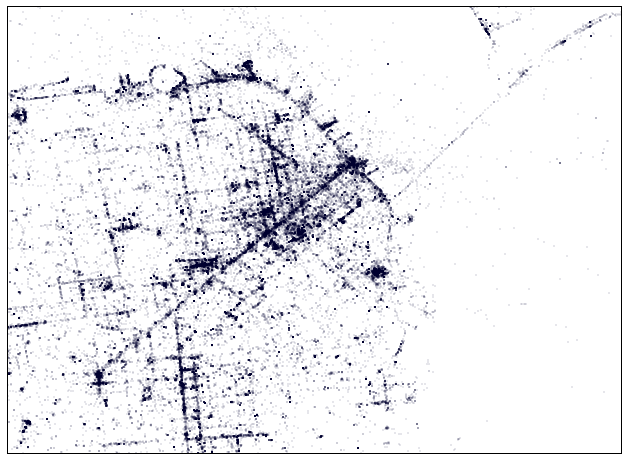

In [29]:
plt.figure(figsize=(11,8))
Xdeg = Xtrain*180/np.pi
plt.scatter(Xdeg[:,0], Xdeg[:,1], s=1, alpha=0.1)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.xlim(-122.45,-122.35)
plt.ylim(37.75, 37.82)
plt.savefig('../slides/scatter.png', bbox_inches='tight', transparent=True)

In [ ]:
kde = KernelDensity(bandwidth=1e-4, metric='haversine')
kde.fit(Xtrain)

In [ ]:
n = 100
X = np.linspace(Xtrain[:,0].min(), Xtrain[:,0].max(), n)
Y = np.linspace(Xtrain[:,1].min(), Xtrain[:,1].max(), n)
X, Y = np.meshgrid(X, Y)
xy = np.vstack((X.flat, Y.flat)).T
Z = kde.score_samples(xy).reshape(n,n)

In [ ]:
plt.hist(Z.flat, bins=50);

In [ ]:
def f(x):
    return 1/(1 + np.exp(x))

In [ ]:
x = np.linspace(-5, 5, 100)
plt.plot(x, f(x))

In [ ]:
Zn = Z.copy()
delta = np.max(Zn) - np.median(Zn)
Zn = (Zn - np.median(Zn))/delta
Zn = f(Zn)
#cutoff = np.percentile(Zn, 10)
#Zn[Zn < cutoff] = cutoff

[]

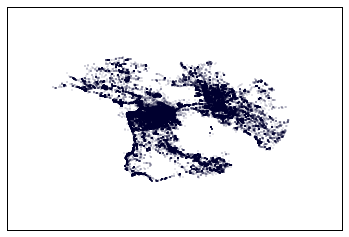

In [9]:
levels = np.linspace(0, Z.max(), 25)
plt.pcolor(X, Y, Z, cmap=plt.cm.Reds)
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=1, alpha=0.1)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
#plt.savefig('../slides/kernel-density.png', transparent=True)

In [ ]:
from sklearn.externals import joblib

In [ ]:
#joblib.dump(kde, 'model-kde-200k-1km.pkl')

## Compute scenery scores for routes

In [21]:
from sklearn.externals import joblib
from scenicstroll.route_db import RouteDB

In [25]:
kde = joblib.load('model-kde-200k-1km.pkl')
db = RouteDB('postgresql:///scenicstroll')

In [26]:
import numpy as np

In [27]:
def f(x):
    return 1/(1 + np.exp(x))

class SceneryModel:
    
    def __init__(self, model):
        self.model = model
        
    def score_samples(self, X):
        scores = self.model.score_samples(X)
        scores -= np.median(scores)
        scores /= np.max(scores)
        return f(scores)

In [12]:
db.session.rollback()

In [28]:
model = SceneryModel(kde)
db.update_scores(model)

In [29]:
db.session.commit()